In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .master("local") \
    .appName("GradientBoostedTrees") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
#renaming winPlaceClass with label
data = data.withColumn("winPlaceClass", col("winPlaceClass") -1)
data = data.withColumnRenamed('winPlaceClass', 'label')
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('label', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDistance_SU

In [3]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label']
inputCols = list(set(inputCols) - set(toRemove))

In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [5]:
seed = 42
withReplacement=False
output = output.sample(withReplacement, 0.1, seed).select("label", "features")

(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 141090
testing: 60342


In [6]:
training.groupBy('label').count().toPandas()

,label,count
0,1,32952
1,3,34920
2,5,3316
3,4,33578
4,2,33087
5,0,3237


In [7]:
def plot_importances(models_list, top=10):
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,2,figsize=(12,16))
    
    for i, m in enumerate(models_list):
        features_importances = pd.Series(m.featureImportances.toArray(), index=inputCols)
        features_importances = features_importances.nlargest(top)

        plt.subplot(3,2,i+1)
        ax = sns.barplot(features_importances.index, features_importances.values)
        ax.tick_params(axis='x', rotation=70)
        ax.set(ylabel='importance')
        plt.title(f"Feature importance for class {i+1}")

    fig.tight_layout()
    fig.savefig('GBTfeatureImportance.pdf', bbox_inches='tight')
    plt.show()

Non fattibile...

gbt = GBTClassifier(stepSize=0.1,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')

paramGrid = ParamGridBuilder() .addGrid(gbt.maxDepth, [5, 10, 15])  \
    .addGrid(gbt.minInstancesPerNode, [50]) \
    .addGrid(gbt.subsamplingRate, [0.5, 1]) \
    .addGrid(gbt.maxIter, [100, 150]) \
    .addGrid(gbt.minInfoGain, [0.0]) \
    .addGrid(gbt.maxBins, [100]) \
    .build()

ovr = OneVsRest(classifier=gbt)

crossval = CrossValidator(estimator=ovr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3) 

cvModel = crossval.fit(training)

Best parameters
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

Gradient Boosted Trees supporta solo la classificazione binaria in pyspark, si creano 6 modelli GBT per ogni classe usando OneVsRest Classifier.

In [27]:
gbt = GBTClassifier(maxIter=100, maxDepth=8, subsamplingRate=0.8,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt, labelCol='label', predictionCol='prediction')
model = ovr.fit(training)

In [28]:
predictions = model.transform(testing)

In [29]:
predictions.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: string (nullable = true)
 |-- prediction: double (nullable = true)



rawPrediction è string e da crea problemi nell'utilizzo del dataframe, si droppa la colonna

In [30]:
predictions = predictions.drop('rawPrediction')

In [31]:
predictions.show(5)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    0|(51,[0,1,2,3,4,5,...|       1.0|
|    0|(51,[0,1,2,3,4,5,...|       0.0|
|    0|(51,[0,1,2,3,4,5,...|       2.0|
|    0|(51,[0,1,2,3,4,5,...|       1.0|
|    0|(51,[0,1,2,3,4,5,...|       1.0|
+-----+--------------------+----------+
only showing top 5 rows



In [32]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [0.0, 1.0, 2.0 ,3.0, 4.0, 5.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.72921784742049
Precision = 0.7270992561598106
F1 measure = 0.7265836393601443
Accuracy = 0.72921784742049
Class 0.0 precision = 0.6066481994459834
Class 0.0 recall = 0.3062937062937063
Class 0.0 F1 Measure = 0.4070631970260222
Class 1.0 precision = 0.748800756705628
Class 1.0 recall = 0.7897812299579563
Class 1.0 F1 Measure = 0.7687452313241313
Class 2.0 precision = 0.6590711805555556
Class 2.0 recall = 0.6502283756779903
Class 2.0 F1 Measure = 0.6546199166546918
Class 3.0 precision = 0.7053342956498917
Class 3.0 recall = 0.7121091679915209
Class 3.0 F1 Measure = 0.7087055410884397
Class 4.0 precision = 0.8053746486597655
Class 4.0 recall = 0.8218833076815447
Class 4.0 F1 Measure = 0.8135452373532771
Class 5.0 precision = 0.7492984097287184
Class 5.0 recall = 0.5808556925308195
Class 5.0 F1 Measure = 0.6544117647058824
Confusion Matrix
[[4.3800e+02 9.6300e+02 2.7000e+01 1.0000e+00 1.0000e+00 0.0000e+00]
 [2.8000e+02 1.1083e+04 2.5780e+03 8.8000e+01 4.0000e+00 0.0000e+00]
 [4

In [18]:
gbt = GBTClassifier(maxIter=150, maxDepth=10, subsamplingRate=0.5,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt)
model = ovr.fit(training)

In [19]:
predictions = model.transform(testing)

In [20]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

Recall = 0.7173992430781488
Precision = 0.7151127244701496
F1 measure = 0.7154529335678037
Accuracy = 0.7173992430781488


Con i parametri simili a quelli del miglior Decision Tree

In [39]:
gbt = GBTClassifier(maxIter=100, maxDepth=10, subsamplingRate=0.8, maxBins=128,
                    minInstancesPerNode=30, minInfoGain=0.0,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt)
model = ovr.fit(training)

In [40]:
predictions = model.transform(testing)

In [41]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

Recall = 0.7288692649890445
Precision = 0.726853907703553
F1 measure = 0.7263832408243072
Accuracy = 0.7288692649890446


In [42]:
gbt = GBTClassifier(maxIter=120, maxDepth=8, subsamplingRate=0.9, maxBins=64,
                    minInstancesPerNode=10, minInfoGain=0.0,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt)
model = ovr.fit(training)

In [43]:
predictions = model.transform(testing)

In [44]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

Recall = 0.7296494256689463
Precision = 0.7275140940283782
F1 measure = 0.7271396355469912
Accuracy = 0.7296494256689463


In [45]:
gbt = GBTClassifier(maxIter=120, maxDepth=8, subsamplingRate=0.9, maxBins=64,
                    minInstancesPerNode=1, minInfoGain=0.0,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt)
model = ovr.fit(training)

In [46]:
predictions = model.transform(testing)

In [47]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

Recall = 0.7283214925967731
Precision = 0.7261404462111776
F1 measure = 0.7257916837353166
Accuracy = 0.7283214925967731


In [51]:
gbt = GBTClassifier(maxIter=100, maxDepth=5, subsamplingRate=0.9, maxBins=64,
                    minInstancesPerNode=10, minInfoGain=0.0,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt)
model = ovr.fit(training)

In [52]:
predictions = model.transform(testing)

In [53]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

Recall = 0.7296494256689463
Precision = 0.727889473980648
F1 measure = 0.7262292817834816
Accuracy = 0.7296494256689463


## Final Model
Scegliamo il modello con F1 measure più alta

In [10]:
%%time
gbt = GBTClassifier(maxIter=120, maxDepth=8, subsamplingRate=0.9, maxBins=64,
                    minInstancesPerNode=10, minInfoGain=0.0,
                    labelCol="label", seed=42, featureSubsetStrategy='auto')
ovr = OneVsRest(classifier=gbt)
finalModel = ovr.fit(training)

CPU times: user 248 ms, sys: 69.4 ms, total: 318 ms
Wall time: 24min 47s


In [11]:
predictions = finalModel.transform(testing)

In [13]:
predictions = predictions.drop('rawPrediction')

In [14]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [0.0, 1.0, 2.0 ,3.0, 4.0, 5.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.7332372145437672
Precision = 0.731621237535386
F1 measure = 0.7307254240728762
Accuracy = 0.7332372145437672
Class 0.0 precision = 0.6265734265734266
Class 0.0 recall = 0.30960608154803043
Class 0.0 F1 Measure = 0.4144310823311749
Class 1.0 precision = 0.7539041464728056
Class 1.0 recall = 0.785909760718546
Class 1.0 F1 Measure = 0.7695743291991618
Class 2.0 precision = 0.6569143186567702
Class 2.0 recall = 0.6520743919885551
Class 2.0 F1 Measure = 0.654485407617475
Class 3.0 precision = 0.7063351095322676
Class 3.0 recall = 0.7217180883242589
Class 3.0 F1 Measure = 0.7139437462597248
Class 4.0 precision = 0.8151054103841168
Class 4.0 recall = 0.8289044612502602
Class 4.0 F1 Measure = 0.8219470244238045
Class 5.0 precision = 0.7693050193050193
Class 5.0 recall = 0.5800582241630277
Class 5.0 F1 Measure = 0.6614107883817427
Confusion Matrix
[[4.4800e+02 9.7100e+02 2.7000e+01 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.5800e+02 1.1200e+04 2.6980e+03 9.2000e+01 3.0000e+00 0.0000e+00]


In [16]:
finalModel.models

[GBTClassificationModel: uid = GBTClassifier_497e24de1582, numTrees=120, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_497e24de1582, numTrees=120, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_497e24de1582, numTrees=120, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_497e24de1582, numTrees=120, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_497e24de1582, numTrees=120, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_497e24de1582, numTrees=120, numClasses=2, numFeatures=51]

Exception ignored in: <function JavaModelWrapper.__del__ at 0x7fe89226d0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pyspark/mllib/common.py", line 137, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages

<Figure size 432x288 with 0 Axes>

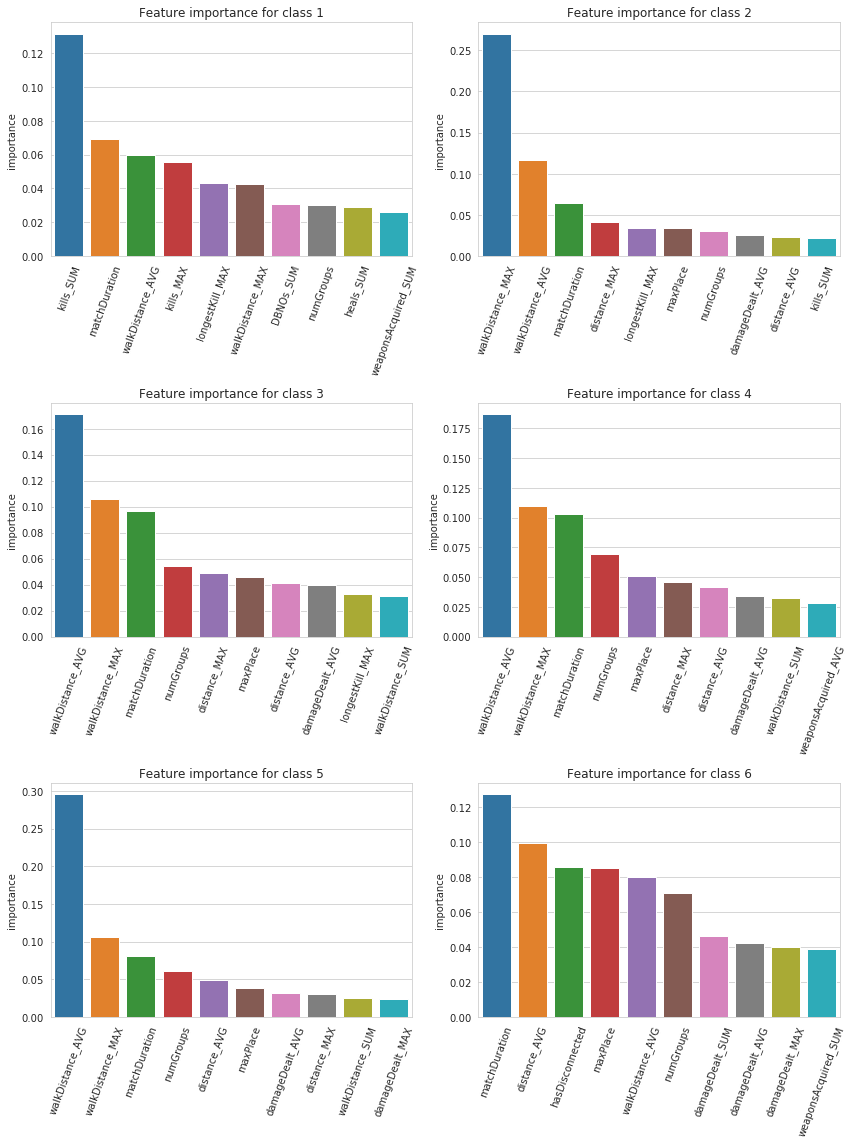

In [18]:
plot_importances(finalModel.models)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.31      0.41      1447
           1       0.75      0.79      0.77     14251
           2       0.66      0.65      0.65     13980
           3       0.71      0.72      0.71     14877
           4       0.82      0.83      0.82     14413
           5       0.77      0.58      0.66      1374

    accuracy                           0.73     60342
   macro avg       0.72      0.65      0.67     60342
weighted avg       0.73      0.73      0.73     60342



In [22]:
print(confusion_matrix(y_true, y_pred))

[[  448   971    27     0     0     1]
 [  258 11200  2698    92     3     0]
 [    9  2661  9116  2152    40     2]
 [    0    23  2024 10737  2090     3]
 [    0     1    12  2220 11947   233]
 [    0     0     0     0   577   797]]


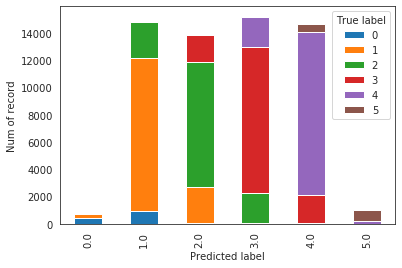

In [25]:
cross_tab = predictions.crosstab('prediction', 'label').toPandas().sort_values(by=["prediction_label"]).set_index('prediction_label')
sns.set_style('white')
cross_tab.plot.bar(stacked=True)

plt.ylabel("Num of record")
plt.xlabel("Predicted label")
plt.legend(title="True label")

plt.savefig("confMatrixGraph_GBT.pdf")